In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Layer, Flatten
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
batch_size = 512
img_size = 224

datagen = ImageDataGenerator(rescale=1/255.,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest',
                             validation_split=0.15)

train_generator = datagen.flow_from_directory('/content/drive/MyDrive/new dataset/New folder/train',
                                                target_size=(img_size, img_size),
                                                batch_size=batch_size,
                                                shuffle=True,
                                                class_mode='categorical',
                                                subset='training')

validation_generator = datagen.flow_from_directory('/content/drive/MyDrive/new dataset/New folder/test',
                                                    target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    class_mode='categorical',
                                                    subset='validation')

Found 4442 images belonging to 2 classes.
Found 94 images belonging to 2 classes.


In [4]:
base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (img_size,img_size,3))

last = base_model.layers[-2].output
x = GlobalAveragePooling2D()(last)
x = Dense(512,'relu')(x)
x = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [5]:
model_name = "model.keras"  # Change the extension to .keras
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [6]:
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator,
                    callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/15
9/9 [==============================] - ETA: 0s - loss: 0.5518 - accuracy: 0.7614  
Epoch 1: val_loss improved from inf to 0.64979, saving model to model.keras
9/9 [==============================] - 664s 67s/step - loss: 0.5518 - accuracy: 0.7614 - val_loss: 0.6498 - val_accuracy: 0.6277 - lr: 1.0000e-04
Epoch 2/15
9/9 [==============================] - ETA: 0s - loss: 0.3512 - accuracy: 0.8404  
Epoch 2: val_loss improved from 0.64979 to 0.48282, saving model to model.keras
9/9 [==============================] - 561s 61s/step - loss: 0.3512 - accuracy: 0.8404 - val_loss: 0.4828 - val_accuracy: 0.7340 - lr: 1.0000e-04
Epoch 3/15
9/9 [==============================] - ETA: 0s - loss: 0.2704 - accuracy: 0.8841  
Epoch 3: val_loss improved from 0.48282 to 0.34215, saving model to model.keras
9/9 [==============================] - 562s 61s/step - loss: 0.2704 - accuracy: 0.8841 - val_loss: 0.3421 - val_accuracy: 0.8617 - lr: 1.0000e-04
Epoch 4/15
9/9 [============================

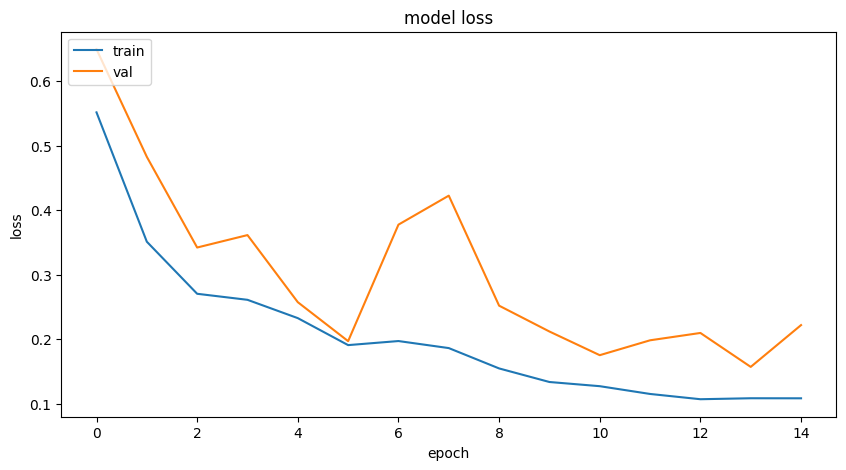

In [7]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

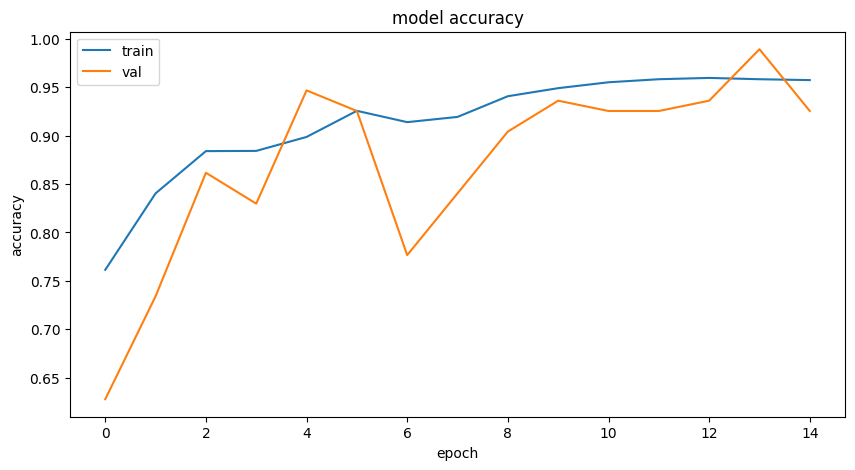

In [8]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [9]:
from sklearn.metrics import classification_report

In [10]:
y_val = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred,axis=1)

1/1 [==============================] - 4s 4s/step


In [11]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93        35
           1       0.94      0.98      0.96        59

    accuracy                           0.95        94
   macro avg       0.95      0.93      0.94        94
weighted avg       0.95      0.95      0.95        94



In [12]:
class_indices = validation_generator.class_indices
indices = {v:k for k,v in class_indices.items()}

In [13]:
filenames = validation_generator.filenames

In [14]:
val_df = pd.DataFrame()
val_df['filename'] = filenames
val_df['actual'] = y_val
val_df['predicted'] = y_pred
val_df['actual'] = val_df['actual'].apply(lambda x: indices[x])
val_df['predicted'] = val_df['predicted'].apply(lambda x: indices[x])
val_df.loc[val_df['actual']==val_df['predicted'],'Same'] = True
val_df.loc[val_df['actual']!=val_df['predicted'],'Same'] = False
val_df.head(10)

,filename,actual,predicted,Same
0,NORMAL/IM-0001-0001.jpeg,NORMAL,NORMAL,True
1,NORMAL/IM-0003-0001.jpeg,NORMAL,NORMAL,True
2,NORMAL/IM-0005-0001.jpeg,NORMAL,NORMAL,True
3,NORMAL/IM-0006-0001.jpeg,NORMAL,PNEUMONIA,False
4,NORMAL/IM-0007-0001.jpeg,NORMAL,NORMAL,True
5,NORMAL/IM-0009-0001.jpeg,NORMAL,NORMAL,True
6,NORMAL/IM-0010-0001.jpeg,NORMAL,NORMAL,True
7,NORMAL/IM-0011-0001-0001.jpeg,NORMAL,NORMAL,True
8,NORMAL/IM-0011-0001-0002.jpeg,NORMAL,NORMAL,True
9,NORMAL/IM-0011-0001.jpeg,NORMAL,NORMAL,True


In [15]:
val_df = val_df.sample(frac=1).reset_index(drop=True)

In [16]:
# Set the image size
img_size = 224  # Ensure this matches the size you've been using

def readImage(path):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.0  # Normalize pixel values
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))
    n = 0
    # Loop up to the smaller of 15 or the length of temp_df
    for i in range(min(15, len(temp_df))):
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.5, wspace=0.3)
        image_path = f"/content/drive/MyDrive/new dataset/New folder/test/{temp_df.filename[i]}"
        image = readImage(image_path)
        plt.imshow(image)
        plt.title(f'Actual: {temp_df.actual[i]}, Predicted: {temp_df.predicted[i]}')

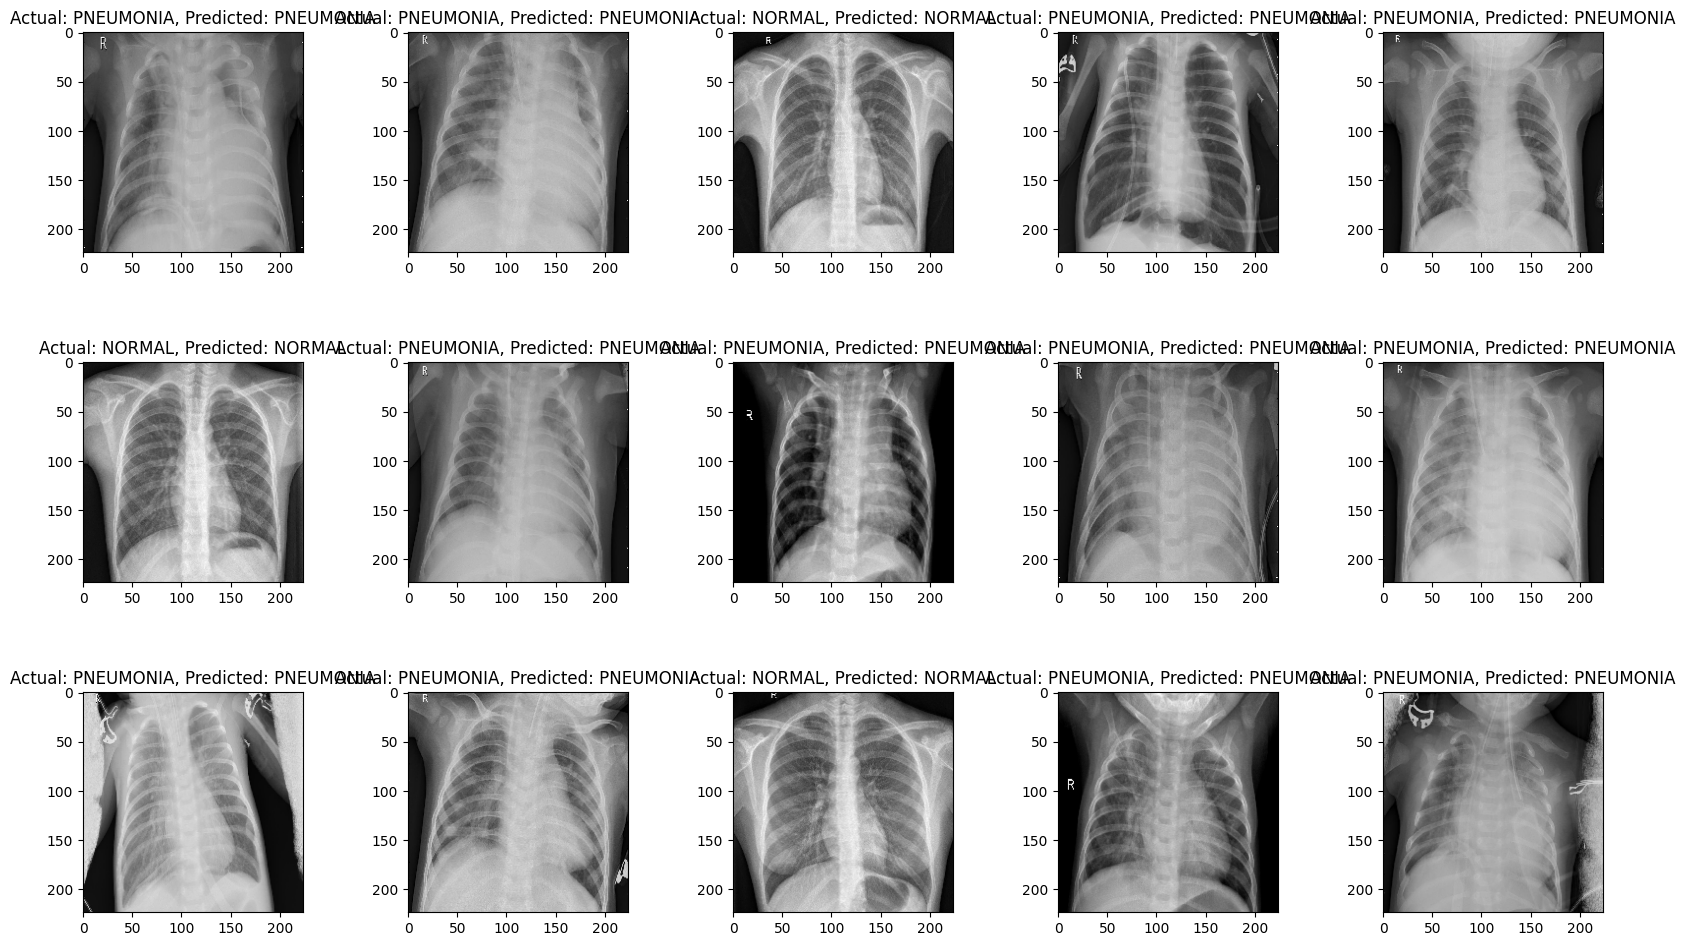

In [17]:
display_images(val_df[val_df['Same']==True])

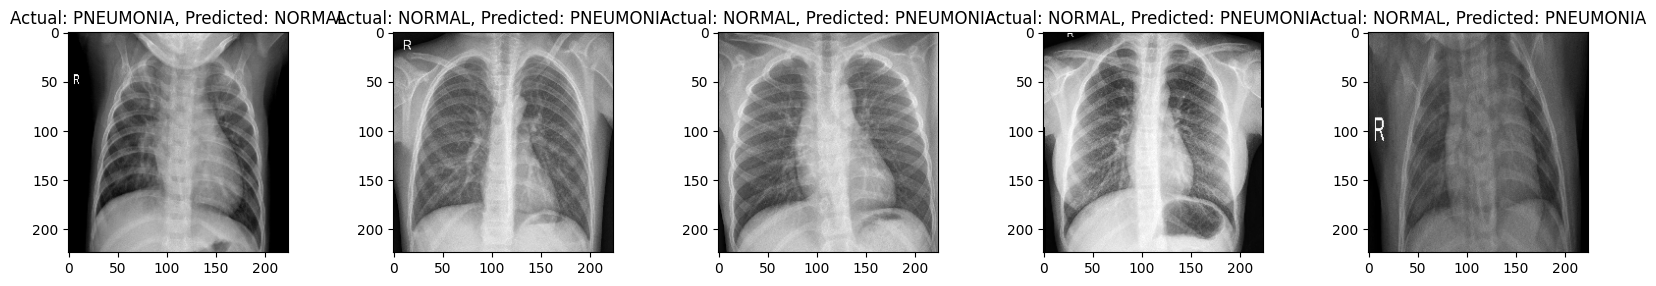

In [ ]:
display_images(val_df[valdf['Same']!=True])_

In [19]:
def make_gradcam_heatmap(img_array, model, pred_index=None):

    grad_model = Model(inputs=model.inputs, outputs=[model.layers[-4].output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), preds

In [20]:
import matplotlib.cm as cm

In [21]:
val_df

,filename,actual,predicted,Same
0,PNEUMONIA/person111_bacteria_535.jpeg,PNEUMONIA,PNEUMONIA,True
1,PNEUMONIA/person113_bacteria_542.jpeg,PNEUMONIA,PNEUMONIA,True
2,NORMAL/IM-0016-0001.jpeg,NORMAL,NORMAL,True
3,PNEUMONIA/person109_bacteria_519.jpeg,PNEUMONIA,PNEUMONIA,True
4,PNEUMONIA/person102_bacteria_487.jpeg,PNEUMONIA,PNEUMONIA,True
...,...,...,...,...
89,PNEUMONIA/person117_bacteria_556.jpeg,PNEUMONIA,PNEUMONIA,True
90,PNEUMONIA/person113_bacteria_543.jpeg,PNEUMONIA,PNEUMONIA,True
91,PNEUMONIA/person114_bacteria_544.jpeg,PNEUMONIA,PNEUMONIA,True
92,PNEUMONIA/person100_bacteria_477.jpeg,PNEUMONIA,PNEUMONIA,True


In [22]:
def gradCAMImage(image):
    path = f"/content/drive/MyDrive/new dataset/New folder/test/{image}"
    img = readImage(path)
    img = np.expand_dims(img,axis=0)
    heatmap,preds = make_gradcam_heatmap(img,model)

    img = load_img(path)
    img = img_to_array(img)
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.8 + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img

In [23]:
def gradcam_of_images(correct_class):
    grad_images = []
    title = []
    temp_df = val_df[val_df['Same']==correct_class]
    temp_df = temp_df.reset_index(drop=True)

    # Get the number of rows in temp_df
    num_rows = len(temp_df)

    # Iterate through the available rows, up to a maximum of 15
    for i in range(min(num_rows, 15)):
        image = temp_df.filename[i]
        grad_image = gradCAMImage(image)
        grad_images.append(grad_image)
        title.append(f"A: {temp_df.actual[i]} P: {temp_df.predicted[i]}")

    return grad_images, title

In [24]:
correctly_classified, c_titles = gradcam_of_images(correct_class=True)
misclassified, m_titles = gradcam_of_images(correct_class=False)

<ipython-input-22-1aaee2d60a69>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


In [25]:
def display_heatmaps(classified_images, titles):
    plt.figure(figsize=(20, 20))
    n = 0
    num_images = len(classified_images) # Get the actual number of images
    for i in range(min(num_images, 15)): # Iterate up to the number of images or 15, whichever is smaller
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.5, wspace=0.3)
        plt.imshow(classified_images[i])
        plt.title(titles[i])
    plt.show()

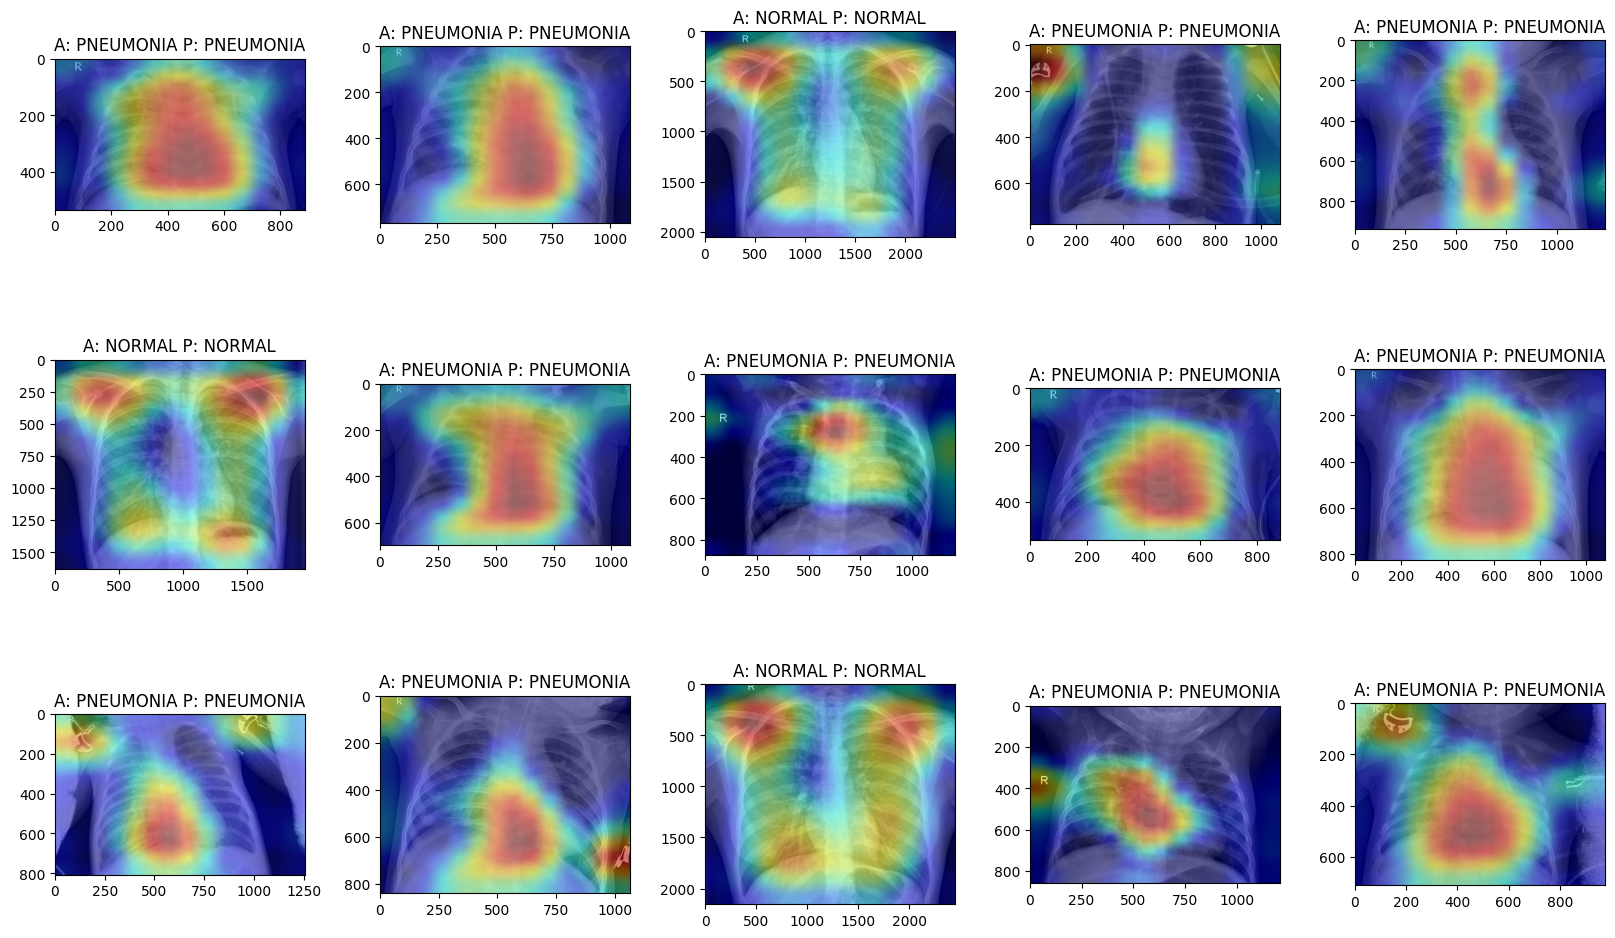

In [26]:
display_heatmaps(correctly_classified,c_titles)

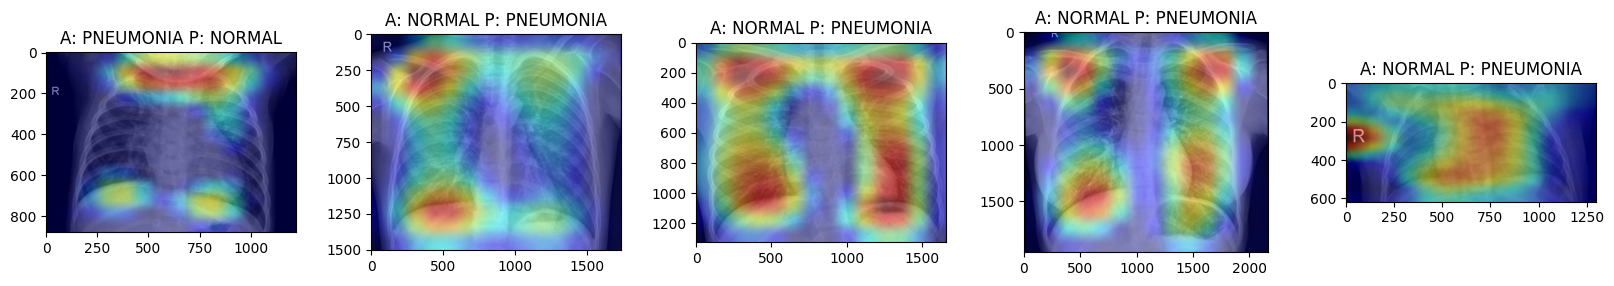

In [27]:
display_heatmaps(misclassified,m_titles)